In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 7.9 MB/s 
     |████████████████████████████████| 596 kB 40.5 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 37.7 MB/s 
     |████████████████████████████████| 895 kB 35.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive

/content/drive/MyDrive


In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv("./explore_cds/train.csv") # from 2015-01-02 to 2019-05-31 (80797 rows)
val_df = pd.read_csv("./explore_cds/validation.csv") # from 2019-06-01 to 2020-03-31 (24184 rows)
test_df = pd.read_csv("./explore_cds/test.csv") # from 2020-04-01 to 2020-06-11 (9043 rows)

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import torch

In [7]:
def check_memory():
    print('GPU memory: %.1f' % (torch.cuda.memory_allocated() // 1024 ** 2))

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [9]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3).to(device)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

Downloading:   0%|          | 0.00/533 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

In [10]:
from tqdm import tqdm
from ast import literal_eval

In [11]:
pd_list = [train_df, val_df, test_df]
new_df = pd.concat(pd_list)

In [12]:
new_df

,Unnamed: 0,title,date,PX10,stock,Company
0,35833,A Few Ways To Play A Stronger US Housing Market,2015-01-02,-0.010900,DHI,DR Horton Inc
1,65442,#Premarket Prep Technical Update - Eli Lilly T...,2015-01-02,-0.000388,LLY,Eli Lilly & Co
2,91108,Could A Ban On Microbeads Overhaul The Cosmeti...,2015-01-02,0.100784,PG,Procter Gamble Co The
3,35413,Stocks Hitting 52-Week Highs,2015-01-02,-0.017365,DGX,Quest Diagnostics Inc
4,65064,Raymond James Upgrades Laboratory of America t...,2015-01-02,-0.000744,LH,Laboratory Corp of America Holdings
...,...,...,...,...,...,...
9038,42616,Morgan Stanley Maintains Overweight on Ford Mo...,2020-06-11,0.094978,F,Ford Motor Co
9039,64404,Shares of several financial service companies ...,2020-06-11,0.099401,L,Loews Corp
9040,84705,Shares of several industrials companies are tr...,2020-06-11,0.125270,NSC,Norfolk Southern Corp
9041,94319,Shares of several financial service companies ...,2020-06-11,0.118619,PRU,Prudential


In [148]:
embeddings = np.zeros((114024,768))
np.set_printoptions(suppress=True)


In [149]:
print(embeddings.shape)

(114024, 768)


In [150]:
i = 0
for index,row in tqdm(new_df.iterrows()):
      inputs = tokenizer(row['title'], return_tensors="pt", max_length=64, padding='max_length', truncation=True).to(device)
      output = finbert(**inputs, output_hidden_states=True)
      avg = torch.mean(output.hidden_states[-1],1)
      embeddings[i] = (avg.cpu().detach().numpy())
      i = i + 1

114024it [30:48, 61.68it/s]


In [151]:
np.save("./explore_cds/embeddings.npy", embeddings)

In [152]:
embeddings = np.load("./explore_cds/embeddings.npy")

In [ ]:
#new_df["embeddings"] = embeddings

In [ ]:
#new_df.to_csv("./explore_cds/embeddings.csv")

In [ ]:
#df = pd.read_csv("./explore_cds/embeddings.csv")

In [154]:
new_df['date'] = pd.to_datetime(new_df['date'])
new_df = new_df.sort_values(by='date')
train_df = new_df[new_df['date']<="2019-01-01"]
val_df = new_df[(new_df['date']>="2019-01-02") & (new_df['date']<"2019-09-30")]
test_df = new_df[new_df['date']>="2019-10-01"] 

In [155]:
len(test_df)

25633

In [156]:
train_embeddings = embeddings[:len(train_df)]
val_embeddings = embeddings[len(train_df):len(train_df)+len(val_df)]
test_embeddings = embeddings[len(train_df)+len(val_df): len(train_df)+len(val_df)+len(test_df)]

In [157]:
print(embeddings)

[[-0.01487753 -1.46931052  0.17819805 ...  0.60474718 -0.02043098
   0.1926259 ]
 [-0.01487753 -1.46931052  0.17819805 ...  0.60474718 -0.02043098
   0.1926259 ]
 [ 0.14198789 -0.73834312 -0.5707351  ...  0.00031242  0.16629334
   0.55066419]
 ...
 [-0.65737957 -0.67524934 -0.08187655 ... -0.10625446  0.4504948
   0.86142075]
 [-0.2198492  -0.50102282  0.75852811 ...  0.19188999 -0.6137796
   0.40896544]
 [-0.69789302 -1.00931168 -0.2034553  ... -0.20119831  0.40683794
   0.49664336]]


In [159]:
len(train_embeddings)

72022

In [160]:
def create_dictionary(df, embeddings):
    i = 0
    dictionary = {}
    for index, row in tqdm(df.iterrows()):
        key = row['Company'] + "%~%" + str(row['date']) + "%~%" + str(row['PX10'])
        if key not in dictionary:
          dictionary[key] = embeddings[i].reshape(768,1)
        else:
          old_array = dictionary[key]
          new_array = np.append(old_array,embeddings[i].reshape(768,1),axis=1)
          dictionary[key] = new_array
        i += 1
    return dictionary

In [161]:
train_dictionary = create_dictionary(train_df, train_embeddings)
val_dictionary = create_dictionary(val_df, val_embeddings)
test_dictionary = create_dictionary(test_df, test_embeddings)

72022it [00:10, 7184.98it/s]
16284it [00:03, 5409.11it/s]
25633it [00:03, 8267.11it/s]


In [162]:
  def get_xy(dictionary):
        CDS_prices = []
        embeddings = []
        for key, value in dictionary.items():
            keys = key.split("%~%")
            company, data, CDS = keys
            CDS_prices.append(CDS)
            embeddings.append(np.average(value,axis=1))
        return [CDS_prices, embeddings]

In [163]:
train_data = get_xy(train_dictionary)
val_data = get_xy(val_dictionary)
test_data = get_xy(test_dictionary)


In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [165]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32,1)
      
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x.double()

In [166]:
class EmbeddingDataset(Dataset):
    def __init__(self, CDS_prices, embeddings):
        self.CDS_prices = CDS_prices
        self.embeddings = embeddings

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self,idx):
        return [self.embeddings[idx], float(self.CDS_prices[idx])]

In [199]:
train_dataset = EmbeddingDataset(train_data[0], train_data[1])
val_dataset = EmbeddingDataset(val_data[0], val_data[1])
test_dataset = EmbeddingDataset(test_data[0], test_data[1])

In [200]:
from torch.utils.data import DataLoader

In [206]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [207]:
# train the model
def train_model(train_dl, val_dl, model, early_stopping=5):
    # define the optimization
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    average_loss = 0
    total_loss = 0
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # compute the model output
            yhat = model(inputs.float())
            targets = targe.unsqueeze(1)
            # calculate loss
            loss = criterion(yhat, targets)
            total_loss += loss
            # clear the gradients
            optimizer.zero_grad()
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        for i, (inputs, targets) in enumerate(val_dl):

        average_loss = total_loss/ len(train_dl)
        total_loss = 0
        print(average_loss)

In [208]:
net = Net()

In [209]:
train_model(train_dataloader, net)

tensor(0.0032, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0022, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0020, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0019, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0019, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0019, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0018, dtype=torch.float64, grad

In [310]:
company_set = set()
net.eval()
target_company = "Alibaba Group Holding Limited"
dates = []
pred = []
target = []
for key, value in test_dictionary.items():
      company, date, CDS = key.split("%~%")
      company_set.add(company)
      if company == target_company:
          output = net(torch.tensor(np.average(value,axis=1),dtype=torch.float))
          pred.append(output.item())
          target.append(float(CDS))
          print(date)
          dates.append(date[0:10])

        

2019-10-03 00:00:00
2019-10-07 00:00:00
2019-10-08 00:00:00
2019-10-09 00:00:00
2019-10-10 00:00:00
2019-10-11 00:00:00
2019-10-14 00:00:00
2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-14 00:00:00
2019-11-15 00:00:00
2019-11-18 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-11-22 00:00:00
2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-09 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-16 00:00:00
2019-12-18 00:00:00


In [311]:
print(company_set)

{'Netflix Inc', 'Northrop Grumman Corp', 'Johnson Controls International plc', 'Constellation Brands Inc', 'Stanley Black & Decker', 'Newmont Mining Corp', 'Avis Budget', 'Toronto-Dominion Bank', 'Allstate Corp', 'Dominion Energy', 'International Game Technology Plc', 'SK Telecom Co Ltd', 'Humana Inc', 'PNC Financial Services', 'HP Inc', 'Cummins Inc', 'UBS Group AG', 'Koninklijke DSM NV', 'Ryder System Inc', 'ASML Holding NV', 'Schlumberger', 'Cisco Systems Inc', 'CAMDEN PROPERTY TRUST', 'Expedia Group Inc', 'Eli Lilly & Co', 'Nisource', 'Hartford Financial Services Group Inc', 'General Mills Inc', 'International Business Machines Corp', "McDonald's Corp", 'Waste Management Inc', 'Pfizer Inc', 'ConocoPhillips', 'Marathon Oil Corp', 'Emerson Electric Co', "Kohl's Corp", 'Kimberly Clark Corp', 'Pioneer Natural Resources Co', 'DTE Energy Co', 'Marsh & McLennan Cos Inc', 'Sherwin-Williams Co/The', 'Baxter International Inc', 'Fiserv Inc', 'NVR Inc', 'Monsanto', 'OI European Group BV', 'AT

In [312]:
df = pd.DataFrame(list(zip(dates, pred, target)),columns =['Dates', 'prediction','target'])

In [313]:
df

,Dates,prediction,target
0,2019-10-03,0.004515,0.007533
1,2019-10-07,0.003281,-0.005868
2,2019-10-08,0.006118,0.006108
3,2019-10-09,0.003501,0.001833
4,2019-10-10,0.005450,-0.001993
...,...,...,...
134,2020-06-03,-0.000624,-0.032024
135,2020-06-04,-0.000771,-0.014643
136,2020-06-08,-0.000509,-0.051442
137,2020-06-09,-0.000953,-0.009574


In [314]:
df['Dates'] = pd.to_datetime(df['Dates'])

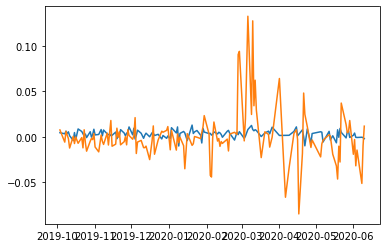

In [315]:
import matplotlib.pyplot as plt

plt.plot(df['Dates'], df['prediction'])
plt.plot(df['Dates'], df['target'])